## Purpose

The objective is to follow augmentation strategy and architecture as in the following link and create replicate the same in K. Need to try to match the validation accuracy of 94%.
Link to refer: https://mc.ai/tutorial-2-94-accuracy-on-cifar10-in-2-minutes/

Moreover we are asked to incorporate OneCycleLR in order to find the best learning rate while training the model.

## Processing CIFAR10 Dataset

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import ReLU
import random

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 512 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 0.000125 #@param ["0.000125", "0.00025", "0.0005"] {type:"raw"}
LEARNING_RATE = 0.4 #@param ["0.4", "0.2", "0.1"] {type:"raw"}
EPOCHS = 24 #@param {type:"slider", min:0, max:100, step:1}
WARMUP = 5 #@param {type:"slider", min:0, max:24, step:1}

In [0]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  X_train.shape
num_test, _, _, _ =  X_test.shape
num_classes = len(np.unique(y_train))

n_train, n_test = X_train.shape[0], X_test.shape[0]
img_size = X_train.shape[1]
n_classes = y_train.max() + 1

170500096/170498071 [==============================] - 9s 0us/step


**Use the mean and standar deviation values as given. We can however calculate the same and normalize the dataset accordingly**

In [0]:
cifar10_mean = (0.4914, 0.4822, 0.4465) # equals np.mean(train_set.train_data, axis=(0,1,2))/255
#cifar10_std = (0.2471, 0.2435, 0.2616) # equals np.std(train_set.train_data, axis=(0,1,2))/255
cifar10_std = (0.2023, 0.1994, 0.2010)

def normalize(x, mean=cifar10_mean, std=cifar10_std, train_data=X_train, given=True):
  if given:
    x, mean, std = [np.array(a, np.float32) for a in (x, mean, std)]
    x -= mean*255
    x *= 1.0/(255*std)
    return x
  else:
    X_train_mean = np.mean(train_data, axis=(0,1,2))
    X_train_std = np.std(train_data, axis=(0,1,2))
    x = (x - X_train_mean) / X_train_std
    return x

Calculating the mean of the dataset so as to use in the CutOut function.

In [0]:
dataset_mean = np.mean([np.mean(np.mean(X_train, axis=(0,1,2))), np.mean(np.mean(X_test, axis=(0,1,2)))])
dataset_mean

121.11835993815103

In [0]:
X_train = normalize(X_train)
X_test = normalize(X_test)

## Augmentation with visualization

In [0]:
from imgaug import augmenters as iaa
import imgaug
import os
import imageio
import numpy as np
from scipy import misc

In [0]:
seq = iaa.Sequential([iaa.SomeOf((0, 2), [
      iaa.Fliplr(1),
      iaa.Noop(),
      iaa.CropAndPad(px=(-4, 4), keep_size=True)
      #iaa.CropAndPad(px=(4, 4), pad_mode=["constant", "edge"]),
      #], random_order=True), iaa.Resize({"height": 32, "width": 32})], random_order=True)
      ], random_order=True)], random_order=True)

In [0]:
def augment_function(input_img, seq=seq, p=0.6, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False, dataset_mean=dataset_mean):
  img_h, img_w, img_c = input_img.shape
  p_1 = np.random.rand()

  if p_1 > p:
      return input_img
  
  nbr = random.randint(1, 10)
  nbr = nbr % 2
  if nbr:
    input_img = seq.augment_image(input_img)

  while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)

      if left + w <= img_w and top + h <= img_h:
          break

  if pixel_level:
      c = np.random.uniform(v_l, v_h, (h, w, img_c))
  else:
      #c = np.random.uniform(v_l, v_h)
      c = dataset_mean

      
  input_img[top:top + h, left:left + w, :] = c

  return input_img

In [0]:
train_datagen = ImageDataGenerator(preprocessing_function=augment_function)
#train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=5, shuffle=False)

In [0]:
x, y = train_generator.next()

W0730 05:52:46.189514 140386199742336 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0730 05:52:46.202497 140386199742336 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0730 05:52:46.214524 140386199742336 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0730 05:52:46.225669 140386199742336 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0730 05:52:46.238281 140386199742336 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


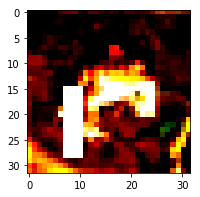

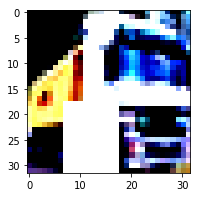

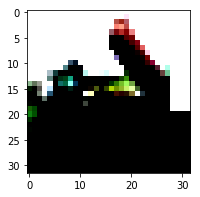

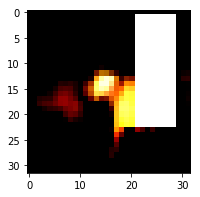

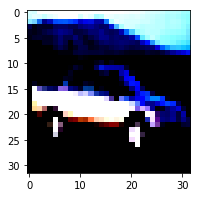

In [0]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

j = 0
for i in range(len(x)):
  fig = plt.figure(figsize=(8,3))
  plt.imshow(x[i])
  j += 1
  if j == 5:
    break

## Data Generator

In [0]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [0]:
#train_datagen = ImageDataGenerator(preprocessing_function=augment_function)
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

## Build Model

In [0]:
def convbnrel(x, k_size=3, channel_nbr=64, max_pool=False):
  x = Conv2D(channel_nbr, kernel_size=(k_size, k_size), strides=(1,1), padding='same', dilation_rate=(1, 1), use_bias=False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  if max_pool:
    x = MaxPooling2D(pool_size=(2, 2))(x)
  return x
  

def residual_layer(x, channel_nbr):
  x = convbnrel(x, channel_nbr=channel_nbr, max_pool=True)
  skip_conn = x
  x = convbnrel(x, channel_nbr=channel_nbr, max_pool=False)
  x = convbnrel(x, channel_nbr=channel_nbr, max_pool=False)
  x = concatenate([skip_conn, x])
  return x

def classifier(x, last_dim, classes, dense=True):
  if dense:
    x = MaxPooling2D(pool_size=(last_dim, last_dim))(x)
    x = Flatten()(x)
    x = Dense(classes, activation='softmax')(x)
    return x
  else:
    x = convbnrel(x, k_size=1, channel_nbr=classes, max_pool=False)
    x = MaxPooling2D(pool_size=(last_dim, last_dim))(x)
    x = Flatten()(x)
    x = Activation('softmax')(x)
    return x
  

In [0]:
def build_model(input_shape=(32, 32, 3,), optimizer_fn='SGD',dense=True):
  
  model_input = Input(shape=input_shape)
  prep_x = convbnrel(model_input, channel_nbr=64, max_pool=False)
  res_layer1_x = residual_layer(prep_x, channel_nbr=128)
  layer2_x = convbnrel(res_layer1_x, channel_nbr=256, max_pool=True)
  res_layer2_x = residual_layer(layer2_x, channel_nbr=512)
  output = classifier(res_layer2_x, last_dim=4, classes=10, dense=dense)
  
  model = Model(inputs=[model_input], outputs=[output])
  
  model.compile(optimizer=optimizer_fn, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [0]:
from keras import optimizers
sgd = optimizers.SGD(lr=LEARNING_RATE , decay=WEIGHT_DECAY, momentum=MOMENTUM, nesterov=True)

model = build_model(optimizer_fn=sgd, dense=True)


W0729 14:43:23.928122 140261202085760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 14:43:23.930015 140261202085760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 14:43:23.936534 140261202085760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 14:43:23.983232 140261202085760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0729 14:43:23.984899 1402612020

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

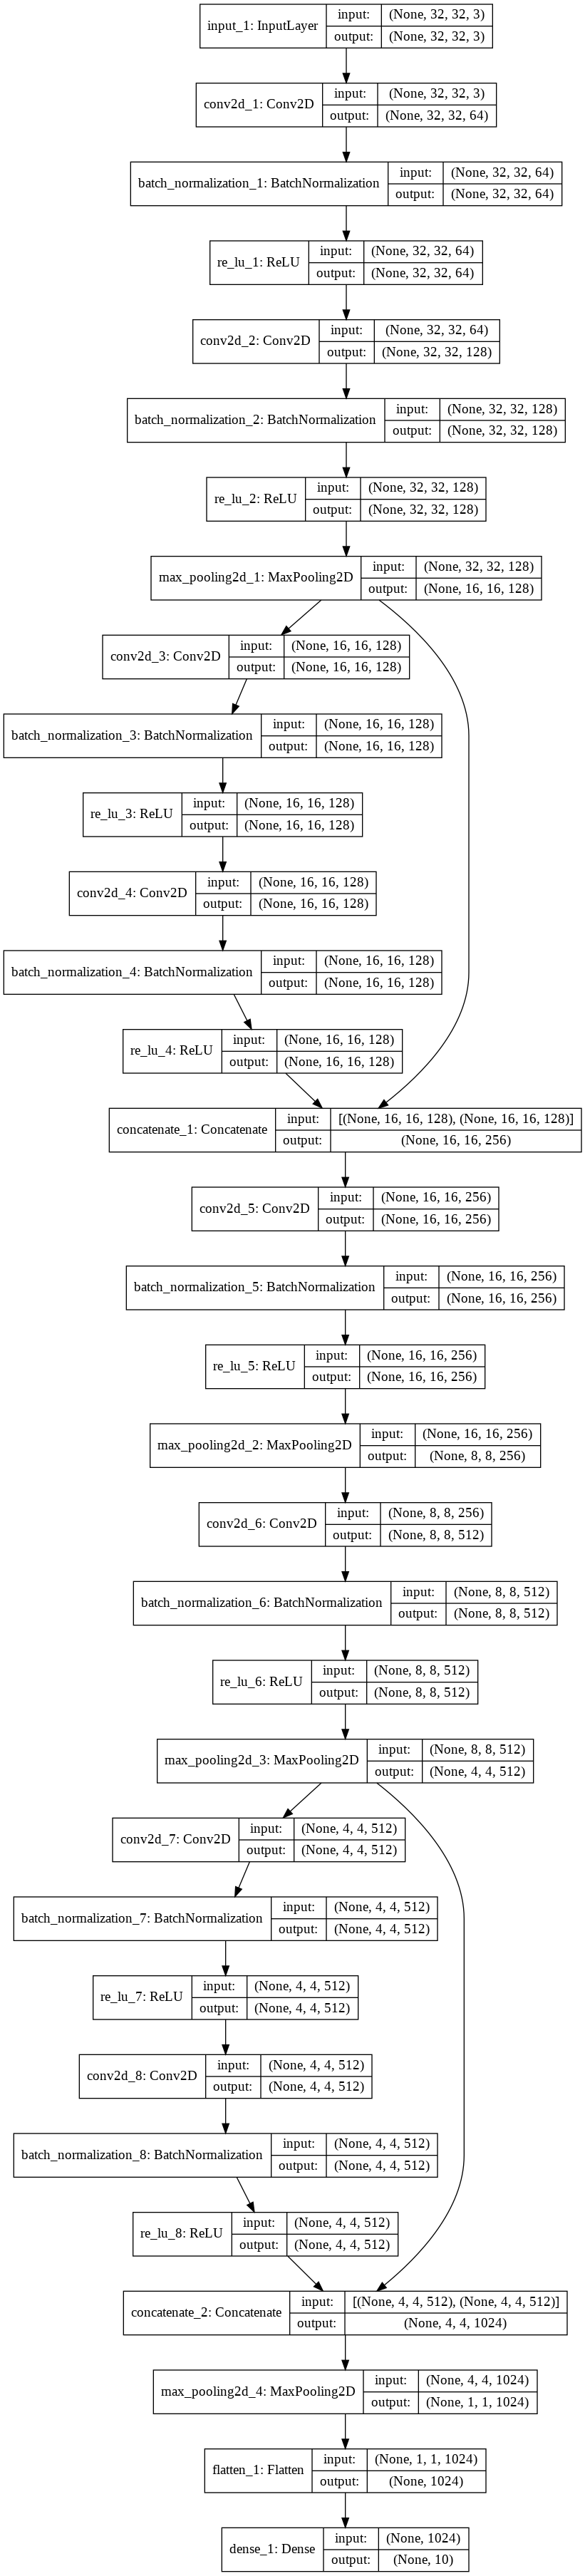

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

## Checkpoint and install OneCycleLR GitHub repo

In [0]:
# Mounting the Google Drive to save the weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/EVA/ASGN12/epochs:{epoch:03d}-val_acc:{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
callbacks_list = [checkpoint]


In [0]:
!git clone -q https://github.com/BPrasad123/keras_one_cycle

In [0]:
from keras_one_cycle import clr

In [0]:
X_train.shape

(50000, 32, 32, 3)

## Find good learning rate

In [0]:
filepath="/content/gdrive/My Drive/EVA/ASGN12/findLR"
#num_samples=X_train.shape[0]
#batch_size=BATCH_SIZE
lr_callback = clr.LRFinder(50000, 512,
                       0.001, 10.0,
                       # validation_data=(X_val, Y_val),
                       lr_scale='exp', save_dir=filepath)

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

# train the model
#start = time.time()
# Train the model
model.fit_generator(train_generator,
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 nb_epoch = 1, 
                                 #validation_data = validation_generator, 
                                 #validation_steps=STEP_SIZE_VALID,
                                 callbacks=[lr_callback],
                                 verbose=0)

 - LRFinder: lr = 0.00109961 
 - LRFinder: lr = 0.00120913 
 - LRFinder: lr = 0.00132957 
 - LRFinder: lr = 0.00146200 
 - LRFinder: lr = 0.00160763 
 - LRFinder: lr = 0.00176776 
 - LRFinder: lr = 0.00194384 
 - LRFinder: lr = 0.00213745 
 - LRFinder: lr = 0.00235036 
 - LRFinder: lr = 0.00258447 
 - LRFinder: lr = 0.00284190 
 - LRFinder: lr = 0.00312497 
 - LRFinder: lr = 0.00343623 
 - LRFinder: lr = 0.00377850 
 - LRFinder: lr = 0.00415486 
 - LRFinder: lr = 0.00456871 
 - LRFinder: lr = 0.00502378 
 - LRFinder: lr = 0.00552418 
 - LRFinder: lr = 0.00607442 
 - LRFinder: lr = 0.00667947 
 - LRFinder: lr = 0.00734479 
 - LRFinder: lr = 0.00807638 
 - LRFinder: lr = 0.00888083 
 - LRFinder: lr = 0.00976542 
 - LRFinder: lr = 0.01073811 
 - LRFinder: lr = 0.01180769 
 - LRFinder: lr = 0.01298381 
 - LRFinder: lr = 0.01427707 
 - LRFinder: lr = 0.01569916 
 - LRFinder: lr = 0.01726289 
 - LRFinder: lr = 0.01898237 
 - LRFinder: lr = 0.02087313 
 - LRFinder: lr = 0.02295222 
 - LRFinde

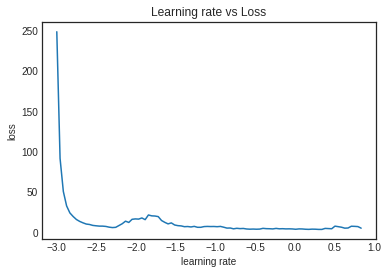

In [0]:
clr.LRFinder.plot_schedule_from_file(filepath)

Here we can see that the loss steadily decreased till learning rate -2.3 and and then it started increasing. Hence we will consider -2.3 as good learning rate and on a log scale the value of learning rate is 0.005

## Finding Optimum Weight-Decay

In [0]:
trainx, trainy = train_generator.next()
valx, valy = validation_generator.next()

In [0]:
filepath="/content/gdrive/My Drive/EVA/ASGN12/findD"
num_samples=X_train.shape[0]
batch_size=BATCH_SIZE
lr_callback = clr.LRFinder(num_samples, batch_size,
                       0.0005, 0.005,
                       validation_data=(valx, valy), validation_sample_rate=5, lr_scale='linear', save_dir=filepath, verbose=True)


In [0]:
WEIGHT_DECAY_FACTORS = [1e-7, 3e-7, 3e-6]

for weight_decay in WEIGHT_DECAY_FACTORS:
  #K.clear_session()
  
  lr_finder = clr.LRFinder(num_samples, batch_size,
                       0.036, 0.36,
                       validation_data=(valx, valy), validation_sample_rate=5, lr_scale='linear', save_dir=filepath, verbose=True)
  
  sgd = optimizers.SGD(lr=LEARNING_RATE , decay=weight_decay, momentum=MOMENTUM, nesterov=True)

  model = build_model(optimizer_fn=sgd, dense=True)  
  
  STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
  STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

  # train the model
  #start = time.time()
  # Train the model
  model.fit_generator(train_generator,
                                   steps_per_epoch=STEP_SIZE_TRAIN,
                                   nb_epoch = 1, 
                                   #validation_data = validation_generator, 
                                   #validation_steps=STEP_SIZE_VALID,
                                   callbacks=[lr_finder],
                                   verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, callbacks=[<keras_on..., verbose=1, epochs=1)`


Epoch 1/1
96/97 [============================>.] - ETA: 0s - loss: 5.0303 - acc: 0.1382 - LRFinder: val_loss: 14.0097 - lr = 0.35331959 
 - LRFinder: val_loss: 13.9047 - lr = 0.35665979 
97/97 [==============================] - 62s 640ms/step - loss: 5.0073 - acc: 0.1389
	LR Finder : Saved the losses and learning rate values in path : {/content/gdrive/My Drive/EVA/ASGN12/findD}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, callbacks=[<keras_on..., verbose=1, epochs=1)`


Epoch 1/1
96/97 [============================>.] - ETA: 0s - loss: 4.1507 - acc: 0.1173 - LRFinder: val_loss: 3.0590 - lr = 0.35331959 
 - LRFinder: val_loss: 3.2463 - lr = 0.35665979 
97/97 [==============================] - 63s 646ms/step - loss: 4.1363 - acc: 0.1175
	LR Finder : Saved the losses and learning rate values in path : {/content/gdrive/My Drive/EVA/ASGN12/findD}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, callbacks=[<keras_on..., verbose=1, epochs=1)`


Epoch 1/1
96/97 [============================>.] - ETA: 0s - loss: 5.5156 - acc: 0.1202 - LRFinder: val_loss: 11.6601 - lr = 0.35331959 
 - LRFinder: val_loss: 11.7037 - lr = 0.35665979 
97/97 [==============================] - 63s 649ms/step - loss: 5.4845 - acc: 0.1200
	LR Finder : Saved the losses and learning rate values in path : {/content/gdrive/My Drive/EVA/ASGN12/findD}


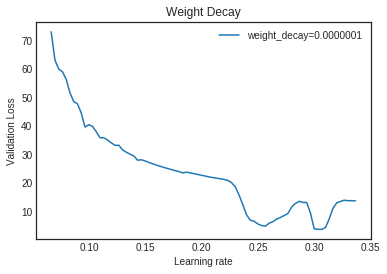

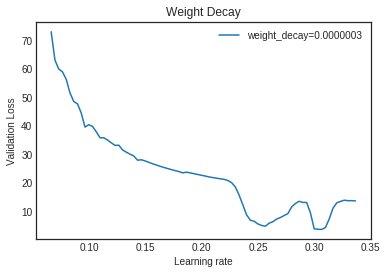

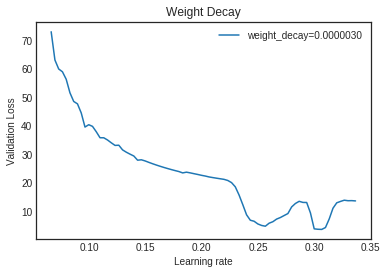

In [0]:
for weight_decay in WEIGHT_DECAY_FACTORS:
    directory = filepath

    losses, lrs = clr.LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='weight_decay=%0.7f' % weight_decay)

    plt.title("Weight Decay")
    plt.xlabel("Learning rate")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.show()

From the above graphs, we do not see any visible difference among those weight decay values. Hence we will consider any of them, such as 1e-7.

## Finding optimum Momentum

In [0]:
MOMENTUMS = [0.9, 0.95, 0.99]
filepath = "/content/gdrive/My Drive/EVA/ASGN12/findM"
weight_decay = 1e-7
for momentum in MOMENTUMS:
  lr_finder = clr.LRFinder(num_samples, batch_size,
                       0.036, 0.36,
                       validation_data=(valx, valy), validation_sample_rate=5, lr_scale='linear', save_dir="/content/gdrive/My Drive/EVA/ASGN12/findM-%s/" %str(momentum), verbose=True)
  
  sgd = optimizers.SGD(lr=0.036 , decay=weight_decay, momentum=momentum, nesterov=True)

  model = build_model(optimizer_fn=sgd, dense=True)  
  
  STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
  STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

  # train the model
  #start = time.time()
  # Train the model
  model.fit_generator(train_generator,
                                   steps_per_epoch=STEP_SIZE_TRAIN,
                                   nb_epoch = 1, 
                                   #validation_data = validation_generator, 
                                   #validation_steps=STEP_SIZE_VALID,
                                   callbacks=[lr_finder],
                                   verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, callbacks=[<keras_on..., verbose=1, epochs=1)`


Epoch 1/1
96/97 [============================>.] - ETA: 0s - loss: 6.2624 - acc: 0.1358 - LRFinder: val_loss: 6.5221 - lr = 0.35331959 
 - LRFinder: val_loss: 6.3388 - lr = 0.35665979 
97/97 [==============================] - 63s 648ms/step - loss: 6.2266 - acc: 0.1359
	LR Finder : Saved the losses and learning rate values in path : {/content/gdrive/My Drive/EVA/ASGN12/findM-0.9/}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, callbacks=[<keras_on..., verbose=1, epochs=1)`


Epoch 1/1
96/97 [============================>.] - ETA: 0s - loss: 4.0444 - acc: 0.1520 - LRFinder: val_loss: 13.1291 - lr = 0.35331959 
 - LRFinder: val_loss: 12.6670 - lr = 0.35665979 
97/97 [==============================] - 63s 649ms/step - loss: 4.0304 - acc: 0.1525
	LR Finder : Saved the losses and learning rate values in path : {/content/gdrive/My Drive/EVA/ASGN12/findM-0.95/}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, callbacks=[<keras_on..., verbose=1, epochs=1)`


Epoch 1/1
96/97 [============================>.] - ETA: 0s - loss: 4.1034 - acc: 0.1160 - LRFinder: val_loss: 14.1264 - lr = 0.35331959 
 - LRFinder: val_loss: 14.1537 - lr = 0.35665979 
97/97 [==============================] - 63s 651ms/step - loss: 4.0896 - acc: 0.1161
	LR Finder : Saved the losses and learning rate values in path : {/content/gdrive/My Drive/EVA/ASGN12/findM-0.99/}


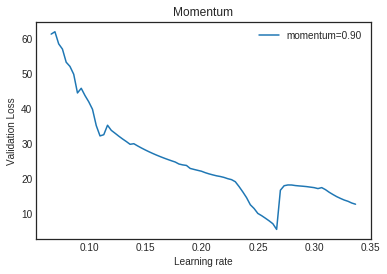

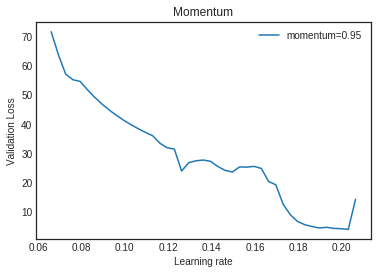

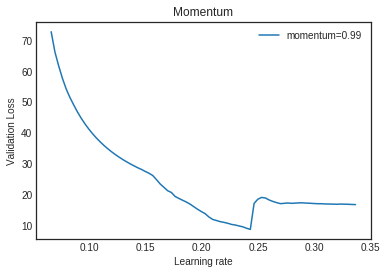

In [0]:
for momentum in MOMENTUMS:
    directory = "/content/gdrive/My Drive/EVA/ASGN12/findM-%s/" %str(momentum)

    losses, lrs = clr.LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='momentum=%0.2f' % momentum)

    plt.title("Momentum")
    plt.xlabel("Learning rate")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.show()

For both 0.90 and 0.99, the loss was seeing a steady decline until there was a sudden spike. Hence will consider consider both 0.90 and 0.99 as minimum and maximum just to see the result of the experiment.

## Training the model with OneCycleLR

In [0]:
num_samples=X_train.shape[0]
num_epoch = 100
batch_size = 128
max_lr = 0.005

lr_manager = clr.OneCycleLR(num_samples, num_epoch, max_lr,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=0.99, minimum_momentum=0.90)

In [0]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/EVA/ASGN12/final/epochs:{epoch:03d}-val_acc:{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [0]:
train_datagen = ImageDataGenerator(preprocessing_function=augment_function)
#train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:


In [0]:
sgd = optimizers.SGD(lr=0.005 , decay=1e-7, momentum=0.99, nesterov=True)

model = build_model(optimizer_fn=sgd, dense=True)  

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

# train the model
#start = time.time()
# Train the model
model.fit_generator(train_generator,
                                 steps_per_epoch=STEP_SIZE_TRAIN,
                                 nb_epoch = 100, 
                                 validation_data = validation_generator, 
                                 validation_steps=STEP_SIZE_VALID,
                                 callbacks=[checkpoint, lr_manager],
                                 verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=97, validation_data=<keras_pre..., validation_steps=19, callbacks=[<keras.ca..., verbose=1, epochs=100)`


Class: <keras_one_cycle.clr.OneCycleLR object at 0x7f905ce46b38>
Values: {'validation_data': None, 'model': <keras.engine.training.Model object at 0x7f905d4f8c18>, 'initial_lr': 0.005, 'end_percentage': 0.1, 'scale': 0.1, 'max_momentum': 0.9, 'min_momentum': 0.99, 'verbose': True, '_update_momentum': True, 'clr_iterations': 0.0, 'history': {}, 'epochs': 100, 'batch_size': 100, 'samples': 50000, 'steps': None, 'num_iterations': 50000, 'mid_cycle_id': 22500, 'params': {'epochs': 100, 'steps': 97, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}}


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/100
 2/97 [..............................] - ETA: 3:14 - loss: 4.0149 - acc: 0.1191

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.503430). Check your callbacks.
  % delta_t_median)


97/97 [==============================] - 53s 550ms/step - loss: 2.3985 - acc: 0.1512 - val_loss: 2.1352 - val_acc: 0.2357

Epoch 00001: val_acc did not improve from 0.53499
 - lr: 0.00052 - momentum: 0.90 
Epoch 2/100
97/97 [==============================] - 50s 517ms/step - loss: 2.1022 - acc: 0.2327 - val_loss: 1.9353 - val_acc: 0.3079

Epoch 00002: val_acc did not improve from 0.53499
 - lr: 0.00054 - momentum: 0.90 
Epoch 3/100
97/97 [==============================] - 50s 518ms/step - loss: 1.9752 - acc: 0.2797 - val_loss: 1.8183 - val_acc: 0.3432

Epoch 00003: val_acc did not improve from 0.53499
 - lr: 0.00056 - momentum: 0.90 
Epoch 4/100
97/97 [==============================] - 50s 520ms/step - loss: 1.8415 - acc: 0.3294 - val_loss: 1.6565 - val_acc: 0.4101

Epoch 00004: val_acc did not improve from 0.53499
 - lr: 0.00058 - momentum: 0.90 
Epoch 5/100
97/97 [==============================] - 50s 518ms/step - loss: 1.7329 - acc: 0.3711 - val_loss: 1.5252 - val_acc: 0.4523

Epoch